# Garden city: A synthetic dataset and sandbox environment for analysis of pre-processing algorithms for GPS human mobility data

Install the `nomad` package from GitHub

In [ ]:
%pip install git+https://github.com/Watts-Lab/nomad.git

  Cloning https://github.com/Watts-Lab/nomad.git (to revision bucephalus) to /private/var/folders/9v/zcb15thj2wb7b8tn11chj_cw0000gn/T/pip-req-build-2yr0sc4i
  Running command git clone --filter=blob:none --quiet https://github.com/Watts-Lab/nomad.git /private/var/folders/9v/zcb15thj2wb7b8tn11chj_cw0000gn/T/pip-req-build-2yr0sc4i
  Running command git checkout -b bucephalus --track origin/bucephalus
  Switched to a new branch 'bucephalus'
  branch 'bucephalus' set up to track 'origin/bucephalus'.
  Resolved https://github.com/Watts-Lab/nomad.git to commit 74390cee20c4edf199b2ac004d32d61cc3285de8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy.random as npr
from shapely.geometry import box
from pprint import pprint

import nomad.city_gen as cg
from nomad.city_gen import City, Building, Street
import nomad.traj_gen as tg
from nomad.traj_gen import Agent, Population
import nomad.stop_detection as sd
from nomad.constants import DEFAULT_SPEEDS, FAST_SPEEDS, SLOW_SPEEDS, DEFAULT_STILL_PROBS
from nomad.constants import FAST_STILL_PROBS, SLOW_STILL_PROBS, ALLOWED_BUILDINGS

import os
os.environ['TZ'] = 'UTC'

## Generating an example city

To create a city, begin by initializing a `City` of the desired dimension. Then successively add `Buildings` to the city by defining their type, door location, and geometry (either as a bounding box or a list of block coordinates). The door coordinate is given by the street block that the building door faces. The final step is to call `city.get_street_graph()`, which generates the shortest paths between all blocks. As an example, we generate a city in which buildings are arranged in concentric rings, with a park in the center, following a ring of residences, a ring of retail locations, and, finally, an outer ring of workplaces.

In [3]:
# Initialize city
city = City(dimensions=(22, 22))
# add a park
city.add_building(building_type='park', door=(13, 11), bbox=box(9, 9, 13, 13))
# add a home
city.add_building(building_type='home', door=(8, 8), blocks=[(7, 7), (7, 8)])

print("Attributes for building 'h-x8-y8':")
pprint(city.buildings['h-x8-y8'].__dict__)

Attributes for building 'h-x8-y8':
{'blocks': [(7, 7), (7, 8)],
 'building_type': 'home',
 'city': <nomad.city_gen.City object at 0x13e412a50>,
 'door': (8, 8),
 'door_centroid': (8.0, 8.5),
 'geometry': <POLYGON ((8 7, 8 9, 7 9, 7 7, 8 7))>,
 'id': 'h-x8-y8'}


In [4]:
# add remaining homes
city.add_building('home', (9, 8), [(8, 7), (9, 7)])
city.add_building('home', (10, 8), [(10, 7)])
city.add_building('home', (11, 8), [(11, 7)])
city.add_building('home', (13, 6), [(13, 7)])
city.add_building('home', (14, 6), [(14, 7)])
city.add_building('home', (13, 8), [(14, 8)])
city.add_building('home', (13, 9), [(14, 9)])
city.add_building('home', (13, 11), [(14, 11)])
city.add_building('home', (13, 12), [(14, 12)])
city.add_building('home', (15, 13), [(14, 13)])
city.add_building('home', (13, 13), [(13, 14), (14, 14)])
city.add_building('home', (12, 13), [(12, 14)])
city.add_building('home', (11, 13), [(11, 14)])
city.add_building('home', (9, 13), [(9, 14)])
city.add_building('home', (8, 13), [(8, 14)])
city.add_building('home', (7, 15), [(7, 14)])
city.add_building('home', (6, 13), [(7, 13)])
city.add_building('home', (8, 12), [(7, 12)])
city.add_building('home', (8, 10), [(7, 10), (7, 9)])

# add workplaces
city.add_building('work', (3, 4), [(4, 4), (4, 5)])
city.add_building('work', (5, 3), [(5, 4), (5, 5)])
city.add_building('work', (6, 6), bbox=box(6, 4, 8, 6))
city.add_building('work', (8, 6), bbox=box(8, 4, 10, 6))
city.add_building('work', (12, 6), bbox=box(11, 5, 14, 6))
city.add_building('work', (12, 3), bbox=box(11, 4, 14, 5))
city.add_building('work', (15, 3), bbox=box(14, 4, 17, 6))
city.add_building('work', (18, 4), bbox=box(17, 4, 18, 6))
city.add_building('work', (18, 6), bbox=box(16, 6, 18, 8))
city.add_building('work', (15, 9), bbox=box(16, 8, 17, 10))
city.add_building('work', (18, 8), bbox=box(17, 8, 18, 10))
city.add_building('work', (18, 10), bbox=box(16, 10, 18, 12))
city.add_building('work', (18, 13), bbox=box(16, 13, 18, 15))
city.add_building('work', (18, 15), bbox=box(16, 15, 18, 16))
city.add_building('work', (15, 15), bbox=box(15, 16, 18, 17))
city.add_building('work', (14, 15), [(14, 16)])
city.add_building('work', (16, 18), bbox=box(16, 17, 18, 18))
city.add_building('work', (15, 18), bbox=box(14, 17, 16, 18))
city.add_building('work', (13, 18), bbox=box(12, 16, 14, 18))
city.add_building('work', (11, 18), bbox=box(10, 17, 12, 18))
city.add_building('work', (11, 15), bbox=box(10, 16, 12, 17))
city.add_building('work', (8, 18), bbox=box(7, 16, 9, 18))
city.add_building('work', (6, 18), bbox=box(5, 17, 7, 18))
city.add_building('work', (6, 15), bbox=box(5, 16, 7, 17))
city.add_building('work', (3, 16), [(4, 16), (4, 17)])
city.add_building('work', (3, 13), bbox=box(4, 13, 6, 16))
city.add_building('work', (6, 12), bbox=box(4, 12, 6, 13))
city.add_building('work', (3, 10), [(4, 9), (4, 10)])
city.add_building('work', (6, 9), [(5, 9), (5, 10)])
city.add_building('work', (6, 8), [(4, 8), (5, 8)])
city.add_building('work', (3, 6), bbox=box(4, 6, 6, 8))

# add retail places
city.add_building('retail', (0, 1), bbox=box(1, 1, 3, 3))
city.add_building('retail', (3, 0), bbox=box(3, 1, 5, 3))
city.add_building('retail', (5, 0), [(5, 1)])
city.add_building('retail', (5, 3), [(5, 2)])
city.add_building('retail', (6, 0), bbox=box(6, 1, 8, 2))
city.add_building('retail', (6, 3), bbox=box(6, 2, 8, 3))
city.add_building('retail', (9, 3), bbox=box(9, 1, 10, 3))
city.add_building('retail', (12, 3), bbox=box(10, 1, 13, 3))
city.add_building('retail', (14, 3), bbox=box(13, 1, 15, 3))
city.add_building('retail', (15, 3), [(15, 2)])
city.add_building('retail', (16, 3), [(16, 2)])
city.add_building('retail', (15, 0), [(15, 1)])
city.add_building('retail', (16, 0), [(16, 1)])
city.add_building('retail', (17, 3), bbox=box(17, 2, 19, 3))
city.add_building('retail', (18, 0), bbox=box(17, 1, 19, 2))
city.add_building('retail', (19, 0), bbox=box(19, 1, 21, 2))
city.add_building('retail', (18, 3), bbox=box(19, 2, 21, 4))
city.add_building('retail', (18, 5), bbox=box(19, 4, 21, 6))
city.add_building('retail', (18, 7), bbox=box(19, 6, 20, 8))
city.add_building('retail', (21, 7), bbox=box(20, 6, 21, 8))
city.add_building('retail', (18, 10), bbox=box(19, 9, 21, 11))
city.add_building('retail', (18, 11), bbox=box(19, 11, 21, 13))
city.add_building('retail', (18, 13), bbox=box(19, 13, 20, 15))
city.add_building('retail', (21, 13), bbox=box(20, 13, 21, 15))
city.add_building('retail', (21, 16), bbox=box(19, 15, 21, 17))
city.add_building('retail', (21, 18), bbox=box(19, 17, 21, 19))

city.add_building('retail', (21, 19), bbox=box(19, 19, 21, 20))
city.add_building('retail', (20, 21), bbox=box(19, 20, 21, 21))
city.add_building('retail', (17, 18), bbox=box(17, 19, 18, 21))
city.add_building('retail', (16, 18), bbox=box(16, 19, 17, 21))
city.add_building('retail', (14, 18), bbox=box(13, 19, 16, 20))
city.add_building('retail', (15, 21), bbox=box(14, 20, 16, 21))
city.add_building('retail', (13, 21), bbox=box(12, 20, 14, 21))
city.add_building('retail', (12, 18), bbox=box(12, 19, 13, 20))
city.add_building('retail', (11, 18), bbox=box(10, 19, 12, 21))
city.add_building('retail', (9, 18), bbox=box(8, 19, 10, 20))
city.add_building('retail', (9, 21), bbox=box(8, 20, 10, 21))
city.add_building('retail', (6, 21), bbox=box(5, 19, 7, 21))
city.add_building('retail', (4, 21), bbox=box(3, 20, 5, 21))
city.add_building('retail', (4, 18), bbox=box(3, 19, 5, 20))
city.add_building('retail', (2, 18), bbox=box(2, 19, 3, 21))
city.add_building('retail', (1, 18), bbox=box(1, 19, 2, 21))
city.add_building('retail', (3, 17), bbox=box(1, 16, 3, 18))
city.add_building('retail', (3, 15), bbox=box(1, 15, 3, 16))
city.add_building('retail', (3, 14), bbox=box(1, 14, 3, 15))
city.add_building('retail', (3, 12), bbox=box(1, 12, 3, 14))
city.add_building('retail', (3, 11), bbox=box(1, 11, 3, 12))
city.add_building('retail', (3, 10), bbox=box(1, 10, 3, 11))
city.add_building('retail', (3, 8), bbox=box(1, 8, 3, 10))
city.add_building('retail', (3, 7), bbox=box(1, 7, 3, 8))
city.add_building('retail', (0, 5), bbox=box(1, 4, 2, 7))
city.add_building('retail', (3, 6), [(2, 6)])
city.add_building('retail', (3, 5), [(2, 5)])
city.add_building('retail', (3, 4), [(2, 4)])

city.get_street_graph()

# get_street_graph can be expensive so persisting is recommended
city.save('garden-city.pkl')

For future uses, we can simply load the city pkl file. 

In [5]:
city = cg.load('garden-city.pkl')

### Plotting the city

To visualize the city, we can call the `plot_city` method of the `City` class. Doors are plotted as gaps in the boundary of their building.

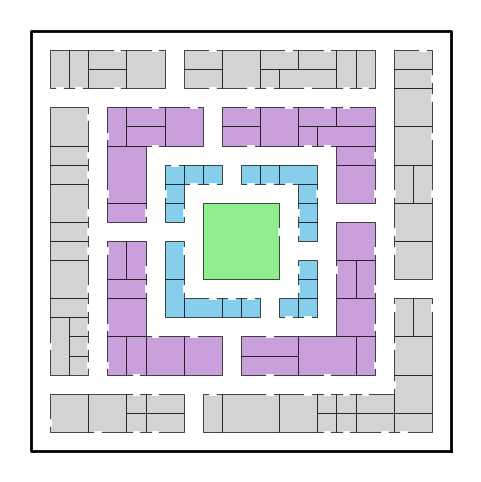

In [6]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=False)

city.plot_city(ax, doors=True, address=False)

# remove axis labels and ticks
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('gc_empty.png')
plt.show()

Each `Building` is assigned a unique identifier by its type and door coordinate. For example, the retail building with door coordinate (12, 3) has the id 'r-x12-y3'. Individual `Buildings` objects and their attributes may be accessed throught the `city.buildings` dictionary.

In [7]:
print(city.buildings['r-x12-y3'].blocks)
city.buildings['r-x12-y3'].door_centroid

[(10, 1), (10, 2), (11, 1), (11, 2), (12, 1), (12, 2)]


(12.5, 3.0)

Once a `City` object has been defined, a `Population` object can be initialized. The `Population` object will contain the `Agents` of the city and generate their trajectories.

In [8]:
# Instantiate population to collect all agents
population = Population(city)

## Agents and trajectories

`Agent`s are tied to a specific `City` instance, and are represented by the `Agent` class. Each `Agent` contains attributes for a work and home location, as well as a 'mobility diary' that is used to generate granular trajectories. When instantiating an `Agent`, their mobility diary can be initialized in two ways:
1. With a user-provided destination diary.
2. Without a diary and then a diary is generated with the EPR model.

These destination diaries are later replaced by a realized mobility diary that takes into account the travel time between buildings and, thus, should be regarded as a mobility plan. 

### User-provided diary initialization

Initializing in this way simply requires passing a `DataFrame` object with appropriate diary columns to the `Agent` constructor. 

In [9]:
# Initialization with custom diary
start_time = [datetime(2024, 1, 1, hour=0, minute=0) + timedelta(minutes=15*t) for t in range(22)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [15]*22  # in minutes
location = ['h-x8-y13'] * 2 + ['r-x12-y3'] * 4 + ['w-x15-y15'] * 12 + ['h-x8-y13'] * 4

d_diary = pd.DataFrame({"unix_timestamp":unix_timestamp,
                        "local_timestamp":start_time,
                        "duration":duration,
                        "location":location})

d_diary = tg.condense_destinations(d_diary)

Alice = Agent(identifier="Alice",
              home='h-x8-y13',
              workplace='w-x15-y15',
              city=city,
              destination_diary=d_diary)

population.add_agent(agent=Alice)
population.generate_trajectory(agent=Alice, seed=100)

print(Alice.diary.head())

   unix_timestamp     local_timestamp  duration   location
0      1704067200 2024-01-01 00:00:00        31   h-x8-y13
1      1704069060 2024-01-01 00:31:00         6       None
2      1704069420 2024-01-01 00:37:00        54   r-x12-y3
3      1704072660 2024-01-01 01:31:00         7       None
4      1704073080 2024-01-01 01:38:00       173  w-x15-y15


The helper function `condense_destinations` simply combines consecutive stops to the same destination. After generating a trajectory with `generate_trajectory` we can see that there are entries with a value of None in the diary, while the destination diary provided was 'complete', this is because the destination diary specifies the building the agent has _planned_ to visit at a given time, but the diary has the information of where the agent's _realized_ location, taking into consideration the travel time between buildings. Hence, a location of None corresponds to `Agent` movement on the streets traveling between buildings.

In [10]:
Alice.__dict__

{'identifier': 'Alice',
 'home': 'h-x8-y13',
 'workplace': 'w-x15-y15',
 'city': <nomad.city_gen.City at 0x1403391d0>,
 'destination_diary': Empty DataFrame
 Columns: [unix_timestamp, local_timestamp, duration, location]
 Index: [],
 'diary':    unix_timestamp     local_timestamp  duration   location
 0      1704067200 2024-01-01 00:00:00        31   h-x8-y13
 1      1704069060 2024-01-01 00:31:00         6       None
 2      1704069420 2024-01-01 00:37:00        54   r-x12-y3
 3      1704072660 2024-01-01 01:31:00         7       None
 4      1704073080 2024-01-01 01:38:00       173  w-x15-y15
 5      1704083460 2024-01-01 04:31:00         4       None
 6      1704083700 2024-01-01 04:35:00        56   h-x8-y13,
 'still_probs': {'park': 0.5, 'home': 0.9, 'work': 0.9, 'retail': 0.5},
 'speeds': {'park': 1.0204081632653061,
  'home': 0.3826530612244898,
  'work': 0.3826530612244898,
  'retail': 0.8928571428571429},
 'dt': 1,
 'trajectory':             x          y     local_timestamp  u

### Diary generation with EPR model

If no diary is provided, `Agent`s are initialized with an empty diary. When calling `Population.generate_trajectory`, the destination diary is generated and then a granular trajectory is sampled from it. Unlike the case with a user-provided diary, this option requires specifying the duration of the trajectory, with a parameter `T` specifying the ending datetime, while the `start_time` is provided when creating the Agent. 

The following agent, Bob, is given home `h-x8-y8` and workplace `w-x18-y4`. We generate a trajectory for Bob that lasts a week from midnight January 1, 2024 to midnight January 8, 2024.

In [11]:
# Initialization and diary generation
Bob = Agent(identifier="Bob",
            home='h-x8-y8',
            workplace='w-x18-y4',
            city=city,
            start_time=datetime(2024, 1, 1, hour=0, minute=0))

population.add_agent(agent=Bob)
population.generate_trajectory(agent=Bob, 
                               T=datetime(2024, 1, 8, hour=0, minute=0))

print(Bob.diary.head())

   unix_timestamp     local_timestamp  duration   location
0      1704067200 2024-01-01 00:00:00       481    h-x8-y8
1      1704096060 2024-01-01 08:01:00         4       None
2      1704096300 2024-01-01 08:05:00        56  p-x13-y11
3      1704099660 2024-01-01 09:01:00         3       None
4      1704099840 2024-01-01 09:04:00       177   w-x15-y9


In [12]:
Bob.trajectory

,x,y,local_timestamp,unix_timestamp,identifier
0,7.500000,8.000000,2024-01-01 00:00:00,1704067200,Bob
1,7.500000,8.000000,2024-01-01 00:01:00,1704067260,Bob
2,7.500000,8.000000,2024-01-01 00:02:00,1704067320,Bob
3,7.500000,8.000000,2024-01-01 00:03:00,1704067380,Bob
4,7.500000,8.000000,2024-01-01 00:04:00,1704067440,Bob
...,...,...,...,...,...
10076,11.784846,7.146775,2024-01-07 23:56:00,1704671760,Bob
10077,11.995111,7.260109,2024-01-07 23:57:00,1704671820,Bob
10078,11.995111,7.260109,2024-01-07 23:58:00,1704671880,Bob
10079,11.815594,7.083339,2024-01-07 23:59:00,1704671940,Bob


To visualize an `Agent`'s trajectory, we can call the `plot_city` method of the `City` class and overlay the points of the trajectory using the `ax.scatter` method of matplotlib.

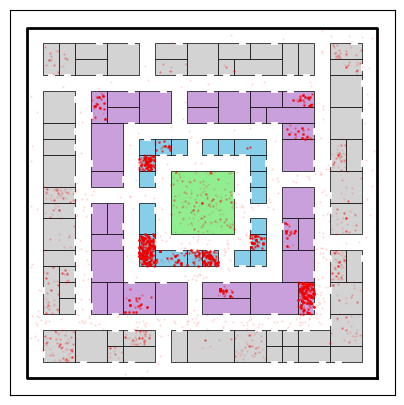

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
city.plot_city(ax, doors=True, address=False, zorder=1)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.scatter(x=Bob.trajectory.x, 
           y=Bob.trajectory.y, 
           s=0.5, color='red', alpha=0.1)

plt.savefig("garden-city-one-user.png")

The following code produces an animation of Bob's movement. We limit the animation to the 24 hours between midnight January 4 to midnight January 5 for speed and tractability of the output.

In [14]:
produce_animation = False

if produce_animation:
    fig, ax = plt.subplots(figsize=(6, 6))

    city.plot_city(ax=ax, doors=True, address=False, zorder=1)

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

    line, = ax.plot([], [], color='blue', alpha=0.1)
    scatter = ax.scatter([], [], s=8, color='black', alpha=0.5)
    time_text = ax.text(0.5, 0.975, '', transform=ax.transAxes)

    fade_length = 60  # Adjust this to control the length of the fade

    df = Bob.trajectory[5760:7200]  # 0:00 Jan 4 – 0:00 Jan 5

    def update(i):
        if i < fade_length:
            current_fade_length = i + 1
        else:
            current_fade_length = fade_length
        alphas = np.array([np.exp(-0.5*x) for x in range(current_fade_length)][::-1])

        line.set_data(df['x'].iloc[:i], df['y'].iloc[:i])
        scatter.set_offsets(df[['x', 'y']].iloc[:i])
        scatter.set_alpha(np.pad(alphas, (i + 1 - current_fade_length, 0), 'constant'))
        time_text.set_text(df['local_timestamp'].iloc[i].strftime('%Y-%m-%d %H:%M:%S'))
        time_text.set_position((0.38, 0.965))
        time_text.set_fontsize(8)
        return line, scatter

    anim = FuncAnimation(fig, update, frames=len(df), interval=50, blit=True)
    anim.save('anim-epr.gif', writer=PillowWriter(fps=20))
    plt.close(fig)

## Sparsifying a complete trajectory

To simulate realistic GPS trajectory data with the sparsity and clusters of pings (or 'burstiness') observed in commercial datasets, we make use of self-exciting point processes—a type of stochastic process that naturally captures triggering and clustering behavior. From a complete ground-truth trajectory, a sparsifed trajectory can be sampled via the `Agent.sample_traj_hier_nhpp` function.

The sampling function `Agent.sample_traj_hier_nhpp` is controlled by three parameters: 
* `beta_start`: the start times of bursts occur according to a Poisson Process with rate 1/`beta_start`
* `beta_dur`: the duration of bursts are sampled from a Exponential distribution with rate 1/`beta_dur`
* `beta_ping`: within a burst, pings are sampled according to a Poisson Process with rate 1/`beta_ping`

These parameters can be interpreted as follows: A burst is expected every `beta_start` minutes and lasts an expected `beta_dur` minutes. Within the burst, a ping is expected to be sampled every `beta_ping` minutes.

Moreover, GPS measurements are often subject to horizontal errors due to various factors like signal obstruction and atmospheric conditions. As such, the sampling function also adds Gaussian noise to the true positions, with the horizontal accuracy indicated in the 'ha' column of the output.

In the example below, we sample from Bob's complete trajectory with the following parameters: `beta_start`=300, `beta_dur`=60, and `beta_ping`=10. 

In [15]:
# Sample sparse trajectory and latent variables for Bob
burst_info = Bob.sample_traj_hier_nhpp(
    beta_start=300, # a burst every 300 mins on average
    beta_durations=60, # average burst duration is 60 mins
    beta_ping=10, # a ping every 10 mins within a burst
    seed=2,
    output_bursts=True)
Bob.sparse_traj.head()

,x,y,local_timestamp,unix_timestamp,identifier,ha
unix_timestamp,,,,,,
1704077760,7.106924,7.786334,2024-01-01 02:56:00,1704077760,Bob,0.75
1704078000,7.287887,7.693551,2024-01-01 03:00:00,1704078000,Bob,0.75
1704078240,7.024951,7.319165,2024-01-01 03:04:00,1704078240,Bob,0.75
1704078360,7.471641,7.815141,2024-01-01 03:06:00,1704078360,Bob,0.75
1704093120,7.057704,7.187391,2024-01-01 07:12:00,1704093120,Bob,0.75


To visualize the distribution of the sparsified pings, set `output_bursts=True` when calling `Agent.sample_traj_hier_nhpp` to obtain information about the start time and duration of bursts. These can then be graphed alongside the sampled pings to visualize the sparsification. The start times are indicated by the red lines and the duration of bursts are shown by grey rectangles. The sampled pings are the black lines.

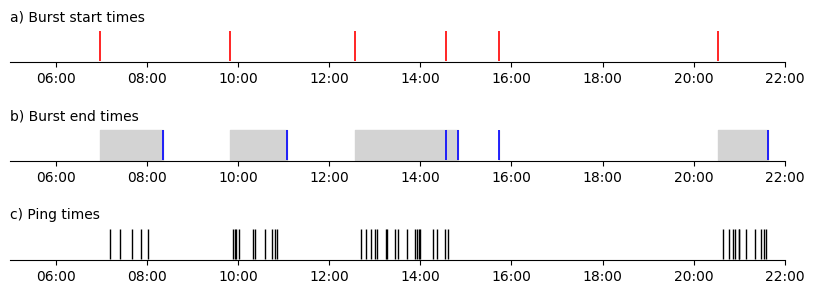

In [16]:
fig, axes = plt.subplots(nrows=3,figsize=(10, 3))
for ax in axes:
    ax.set(xlim=(pd.Timestamp('2024-01-01 05:00'), pd.Timestamp('2024-01-01 22:00')))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    [spine.set_visible(False) for name, spine in ax.spines.items() if name != 'bottom']
    ax.yaxis.set_visible(False)

# Plot burst start times (Ns)
axes[0].vlines(burst_info['start_time'], 0, 1, color='red', linewidth=1.2)
axes[0].set_title('a) Burst start times', loc='left', fontsize=10)

# Plot burst end times (Ne)
for _, row in burst_info.iterrows():
    axes[1].fill_betweenx([0, 1], row['start_time'], row['end_time'], color='lightgrey', zorder=1)
axes[1].vlines(burst_info['end_time'], 0, 1, color='blue', linewidth=1.2)
axes[1].set_title('b) Burst end times', loc='left', fontsize=10)

# Plot pings (N)
axes[2].vlines(Bob.sparse_traj['local_timestamp'], 0, 1, color='black', linewidth=1)
axes[2].set_title('c) Ping times', loc='left', fontsize=10)

fig.subplots_adjust(hspace=2)
fig.savefig("nhpp-sampling.png", bbox_inches='tight')
plt.show()

# Generating multiple agents

A `Population` may contain any number of `Agent`s, which can be initialized en masse using the `Population.generate_agents` method. Each `Agent` is assigned a random name as well as a uniformly sampled home and workplace. The `start_time` parameter indicates the time at which all the `Agent`s start their trajectories.

`Agent` trajectories can be generated by looping over each `Agent` and running the `Population.generate_trajectory` function as explained above. 

_Note: if using a seed, make sure that each agent's seed is different to avoid all agents having the same trajectory._

In [17]:
population2 = Population(city)
population2.generate_agents(N=5,
                            start_time=datetime(2024, 1, 1, hour=8, minute=0),
                            seed=100)

for i, agent_id in enumerate(population2.roster):
    agent = population2.roster[agent_id]
    population.generate_trajectory(agent=agent,
                                   T=datetime(2024, 1, 8, hour=0, minute=0),
                                   seed=100+i)
    agent.sample_traj_hier_nhpp(beta_start=300,
                                beta_durations=60,
                                beta_ping=10,
                                seed=100+i)

population2.roster

{'nifty_saha': <nomad.traj_gen.Agent at 0x1402d6fd0>,
 'nostalgic_wing': <nomad.traj_gen.Agent at 0x1402f2520>,
 'optimistic_brahmagupta': <nomad.traj_gen.Agent at 0x1402f22c0>,
 'peaceful_gates': <nomad.traj_gen.Agent at 0x14024d010>,
 'pedantic_kowalevski': <nomad.traj_gen.Agent at 0x14032b130>}

Any individual `Agent` can be accessed by calling their identifier through the `Population.roster` dictionary. 

In [18]:
nifty_saha = population2.roster['nifty_saha']
print("Diary:\n", nifty_saha.diary.head())
print("\nTrajectory:\n", nifty_saha.trajectory.head())
print("\nSparse Trajectory:\n", nifty_saha.sparse_traj.head())

Diary:
    unix_timestamp     local_timestamp  duration   location
0      1704096000 2024-01-01 08:00:00         1  h-x13-y11
1      1704096060 2024-01-01 08:01:00         5       None
2      1704096360 2024-01-01 08:06:00       235   w-x18-y8
3      1704110460 2024-01-01 12:01:00         2       None
4      1704110580 2024-01-01 12:03:00        28  r-x18-y10

Trajectory:
            x          y     local_timestamp  unix_timestamp  identifier
0  14.500000  11.500000 2024-01-01 08:00:00      1704096000  nifty_saha
1  14.543250  10.602152 2024-01-01 08:01:00      1704096060  nifty_saha
2  15.876826  12.564736 2024-01-01 08:02:00      1704096120  nifty_saha
3  18.313080  11.881745 2024-01-01 08:03:00      1704096180  nifty_saha
4  18.521009   9.244356 2024-01-01 08:04:00      1704096240  nifty_saha

Sparse Trajectory:
                         x          y     local_timestamp  unix_timestamp  \
unix_timestamp                                                             
1704110340      17.

# Example 1: testing stop detection algorithms

As a demonstration of our generative model, we adapt the robustness experiment proposed in Barreras and Watts (2024), which aimed to show that common stop detection algorithms can be impacted by ping sparsity. Our generation of sparse ping times allows for modeling the clustering of pings into bursts, which can produce a more nuanced notion of `sparsity' than overall ping frequency. This toy example reveals how global sparsity might be an inadequate metric to use for calibrating stop-detection algorithms since, even when keeping it constant, changes in the clustering pattern of pings results in important variations of the output and can cause the same problems—such as omitting, merging, or splitting stops.

We first initialize an `Agent` (Charlie) and generate a complete ground-truth trajectory. The destination diary is manually initialized as consecutive 1-hour visits to two homes followed by a 3-hour visit at a larger retail building.

In [19]:
start_time = [datetime(2024, 6, 1, hour=0, minute=0) + timedelta(minutes=60*t) for t in range(5)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*5  # in minutes

location = ['h-x13-y11'] * 1 + ['h-x13-y8'] * 1 + ['r-x18-y10'] * 3

destination = pd.DataFrame(
    {"unix_timestamp": unix_timestamp, "local_timestamp": start_time,
     "duration": duration, "location": location}
)
destination = tg.condense_destinations(destination)

Charlie = Agent(identifier="Charlie",
                home='h-x13-y11',
                workplace='w-x15-y9',
                city=city,
                destination_diary=destination,
                dt=1)

population.add_agent(Charlie)
population.generate_trajectory(Charlie, seed=75)

Charlie.diary

,unix_timestamp,local_timestamp,duration,location
0,1717200000,2024-06-01 00:00:00,61,h-x13-y11
1,1717203660,2024-06-01 01:01:00,2,None
2,1717203780,2024-06-01 01:03:00,58,h-x13-y8
3,1717207260,2024-06-01 02:01:00,4,None
4,1717207500,2024-06-01 02:05:00,176,r-x18-y10


Charlie's ground-truth trajectory is plotted below.

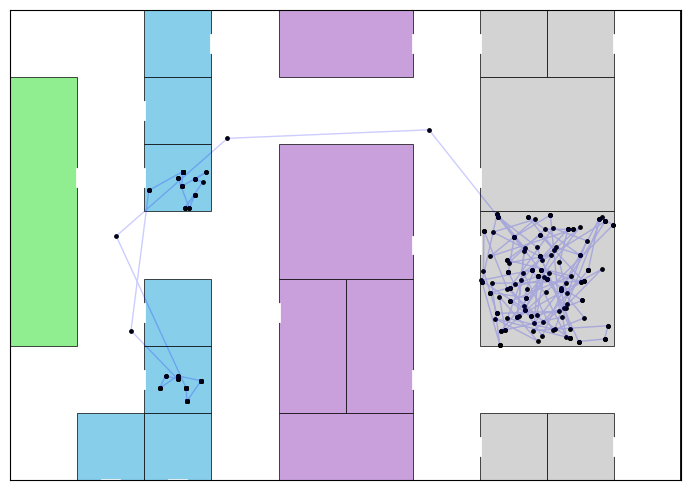

In [20]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(x=Charlie.trajectory.x, 
           y=Charlie.trajectory.y, 
           s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=False, zorder=1)

ax.plot(Charlie.trajectory.x,
        Charlie.trajectory.y,
        linewidth=1, color='blue', alpha=0.2)

ax.set_xlim(12, 22)
ax.set_ylim(7, 14)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig("exp1-trajectory.png")

plt.show()

We sample Charlie's ground-truth trajectory at two levels of sparsity. 
* The higher sparsity sample uses parameters `beta_start`=150, `beta_dur`=20, and `beta_ping`=2. 
* The lower sparsity sample uses parameters `beta_start`=60, `beta_dur`=40, and `beta_ping`=10. 

The high sparsity sample expects a burst every 2.5 hours with a mean length of 20 minutes and a ping expected roughly every 2 minutes within the burst, for an expected total burst period of 40 minutes over 5 hours. The low sparsity sample expects a burst every hour with a mean length of 40 minutes and a ping expected roughly every 5 minutes within the burst, for an expected total burst period of 200 minutes over 5 hours.

Note that both sparsity levels expect 20 pings over the 5-hour duration. We deliberately choose these parameters to hold overall ping frequency fixed in order to isolate the effect of the burstiness pattern.

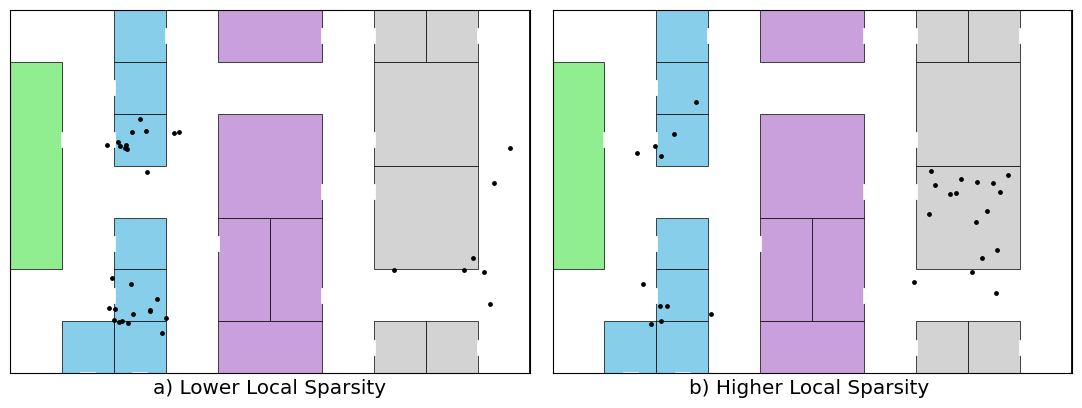

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
hier_nhpp_params = [(150, 20, 2), (60, 40, 10)]
seed = 819

for j in range(2):
    ax = axes[j]
    Charlie.sample_traj_hier_nhpp(*hier_nhpp_params[j], seed=seed)

    ax.scatter(Charlie.sparse_traj.x, Charlie.sparse_traj.y, s=6, color='black', alpha=1, zorder=2)
    city.plot_city(ax, doors=True, address=False, zorder=1)

    ax.set_xlim(12, 22)
    ax.set_ylim(7, 14)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

axes[0].set_xlabel('a) Lower Local Sparsity', fontsize='x-large')
axes[1].set_xlabel('b) Higher Local Sparsity ', fontsize='x-large')

plt.tight_layout()
plt.savefig("exp1-sparse.png")
plt.show()

The distribution of the pings as well as the burst durations for both levels of local sparsity are plotted below.

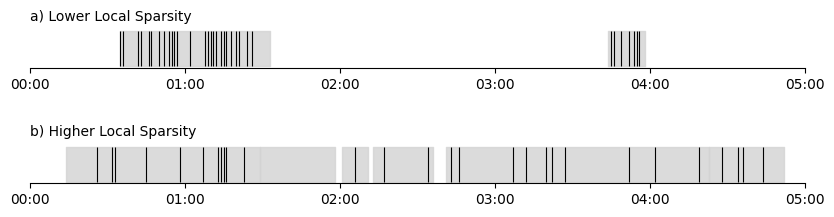

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(10, 2))

for j in range(2):
    ax = axes[j]
    ax.set(xlim=(pd.Timestamp('2024-06-01 00:00'), pd.Timestamp('2024-06-01 05:00')))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    [spine.set_visible(False) for name, spine in ax.spines.items() if name != 'bottom']
    ax.yaxis.set_visible(False)

    burst_info = Charlie.sample_traj_hier_nhpp(*hier_nhpp_params[j], seed=seed, output_bursts=True)

    #ax.vlines(burst_info['start_time'], 0.95, 1.05, color='red', linewidth=1.2, alpha=1)

    for i, row in burst_info.iterrows():
        ax.fill_betweenx(
            [0.95, 1.05],
            row['start_time'],
            row['end_time'],
            color='lightgrey',
            alpha=0.8,
            zorder=1
        )

    ax.vlines(Charlie.sparse_traj['local_timestamp'], 0.95, 1.05, color='black', linewidth=0.8, alpha=1)

axes[0].set_title('a) Lower Local Sparsity', loc='left', fontsize=10)
axes[1].set_title('b) Higher Local Sparsity ', loc='left', fontsize=10)

fig.subplots_adjust(hspace=2)
fig.savefig("exp1-sparsity-levels.png", bbox_inches='tight')

plt.show()

We are interested in how the sparsity of the trajectory and parameterization of stop detection algorithms interact. Here, we use a temporal version of DBSCAN to cluster pings into stops. DBSCAN takes three parameters: `time_thresh`, `dist_thresh`, and `min_pts`. Roughly, a point is considered part of a dense cluster if it has at least `min_pts` neighboring points within a distance `dist_thresh` and time gap `time_thresh`; otherwise, it is labeled as noise. 

We explore a fine and a coarse parameterization of DBSCAN and apply each to the higher and lower sparsity trajectories.

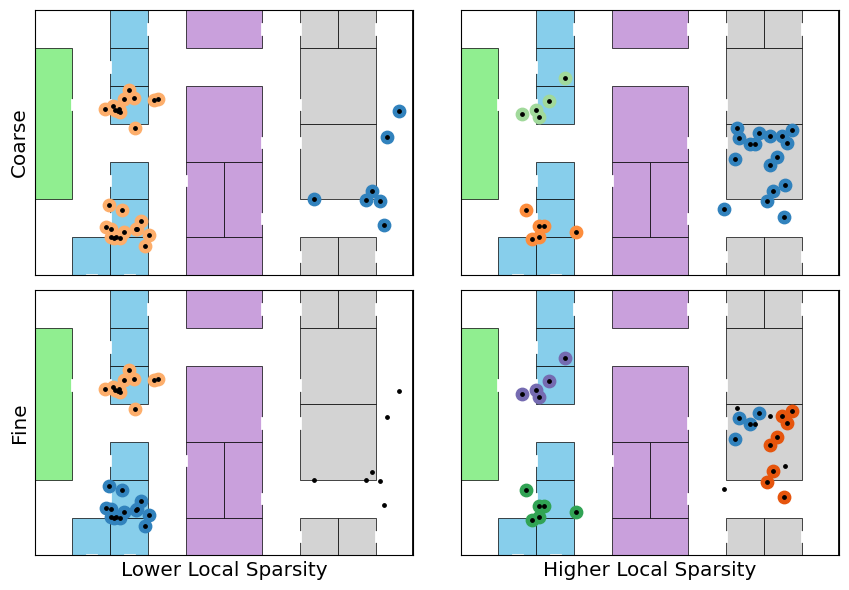

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
dbscan_params = [(120, 2.25, 2), (45, 1, 3)]

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        Charlie.sample_traj_hier_nhpp(*hier_nhpp_params[j], seed=seed)

        dbscan_out = sd.temporal_dbscan(Charlie.sparse_traj, *dbscan_params[i])

        num_clusters = sum(dbscan_out.cluster.unique() > -1)
        for cid in range(num_clusters):
            cpings = dbscan_out[dbscan_out.cluster == cid]
            cdata = Charlie.sparse_traj.loc[cpings.index]
            col = cm.tab20c(cid/(num_clusters+1))
            ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=2)

        ax.scatter(Charlie.sparse_traj.x, Charlie.sparse_traj.y, s=6, color='black', alpha=1, zorder=2)
        city.plot_city(ax, doors=True, address=False, zorder=1)

        ax.set_xlim(12, 22)
        ax.set_ylim(7, 14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

axes[0, 0].set_ylabel('Coarse', fontsize='x-large')
axes[1, 0].set_ylabel('Fine', fontsize='x-large')
axes[1, 0].set_xlabel('Lower Local Sparsity', fontsize='x-large')
axes[1, 1].set_xlabel('Higher Local Sparsity', fontsize='x-large')

plt.tight_layout()
plt.savefig("exp1-stdbscan.png")
plt.show()

In the top left panel, we observe "stop merging", wherein a coarser parametrization struggles to differentiate stops at small neighboring establishments and instead clusters two stops as one. Conversely, a finer parametrization may completely miss a stop at a larger location (as in the bottom left panel) or erroneously cluster a larger stop as two distinct, shorter stops (as in the bottom right panel). Only the top right panel in this example accurately detected the three stops. Thus, it seems like the optimal parameters for a given trajectory could be selected based on the clustering structure and not only on the ping frequency.

# Example 2: The effect of noise on stops and dwell time

We simulate two agents with the same destination diary but different variance parameters. Both agents spend two hours at the park but one agent (Daniel) has 

In [24]:
start_time = [datetime(2024, 6, 1, hour=0, minute=0) + timedelta(minutes=60*t) for t in range(2)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*2  # in minutes

location = ['p-x13-y11'] * 2

destination = pd.DataFrame(
    {"unix_timestamp": unix_timestamp, "local_timestamp": start_time,
     "duration": duration, "location": location}
)
destination = tg.condense_destinations(destination)

init_trajectory = pd.DataFrame([{
    'x': 11.0,
    'y': 11.0,
    'local_timestamp': datetime(2024, 6, 1, hour=0, minute=0),
    'unix_timestamp': int(datetime(2024, 6, 1, hour=0, minute=0).timestamp()),
    'identifier': "Daniel"
}])

init_diary = pd.DataFrame([{
    'unix_timestamp': int(datetime(2024, 6, 1, hour=0, minute=0).timestamp()),
    'local_timestamp': datetime(2024, 6, 1, hour=0, minute=0),
    'duration': 1,
    'location': 'p-x13-y11'
}])

# Daniel is slow
Daniel = Agent(identifier="Daniel",
            home='p-x13-y11',
            workplace='w-x15-y9',
            city=city,
            destination_diary=destination,
            still_probs=SLOW_STILL_PROBS,
            speeds=SLOW_SPEEDS,
            trajectory=init_trajectory,
            diary=init_diary,
            dt=1)
population.add_agent(Daniel)
population.generate_trajectory(Daniel, seed=75)

# Elaine is fast
Elaine = Agent(identifier="Elaine",
            home='p-x13-y11',
            workplace='w-x15-y9',
            city=city,
            destination_diary=destination,
            still_probs=FAST_STILL_PROBS,
            speeds=FAST_SPEEDS,
            trajectory=init_trajectory,
            diary=init_diary,
            dt=1)
population.add_agent(Elaine)
population.generate_trajectory(Elaine, seed=75)

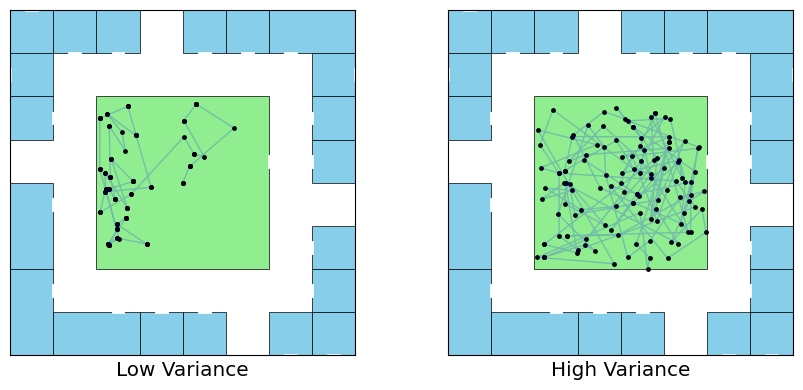

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

for j in range(2):
    ax = axes[j]
    agent = [Daniel, Elaine][j]

    ax.scatter(x=agent.trajectory.x, 
           y=agent.trajectory.y, 
           s=6, color='black', alpha=1, zorder=2)
    city.plot_city(ax, doors=True, address=False, zorder=1)

    ax.plot(agent.trajectory.x,
            agent.trajectory.y,
            linewidth=1, color='blue', alpha=0.2)

    ax.set_xlim(7, 15)
    ax.set_ylim(7, 15)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

axes[0].set_xlabel('Low Variance', fontsize='x-large')
axes[1].set_xlabel('High Variance', fontsize='x-large')

plt.tight_layout()
plt.savefig("exp2-trajectories.png")
plt.show()

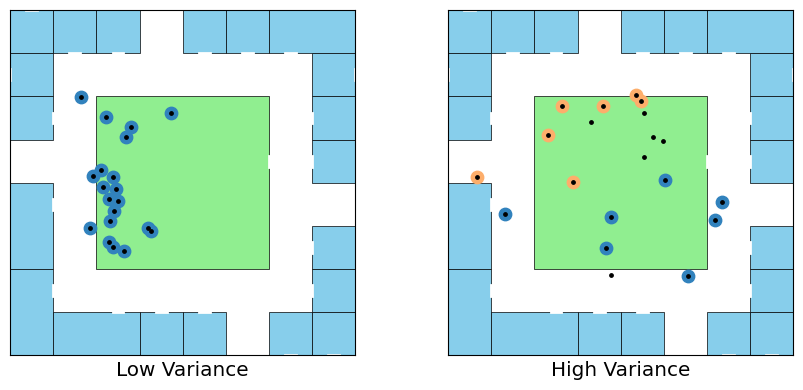

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
hier_nhpp_params = (10, 1000, 5)
lachesis_params = (15, 30, 4)
ha = [3/4, 6/4]
seed = 1000

for j in range(2):
    ax = axes[j]
    agent = [Daniel, Elaine][j]

    agent.sample_traj_hier_nhpp(*hier_nhpp_params, seed=seed, ha=ha[j])

    lachesis_out = sd.lachesis_patches(agent.sparse_traj, *lachesis_params)
    
    num_clusters = sum(lachesis_out.cluster.unique() > -1)
    for cid in range(num_clusters):
        cpings = lachesis_out[lachesis_out.cluster == cid]
        cdata = agent.sparse_traj.loc[cpings.index]
        col = cm.tab20c(cid/(num_clusters+1))
        ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=2)

    ax.scatter(agent.sparse_traj.x, agent.sparse_traj.y, s=6, color='black', alpha=1, zorder=2)
    city.plot_city(ax, doors=True, address=False, zorder=1)

    ax.set_xlim(7, 15)
    ax.set_ylim(7, 15)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

axes[0].set_xlabel('Low Variance', fontsize='x-large')
axes[1].set_xlabel('High Variance', fontsize='x-large')

plt.tight_layout()
plt.savefig("exp2-lachesis.png")
plt.show()